# Generative Advesarial Network Explained

For this exercice, We will create and train the Discriminator and our Generator. 

The purpose of this practice is to generate MNIST number. 

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as dset
import torchvision.datasets as datasets
from torchvision import transforms
from tqdm import tqdm_notebook

In [0]:
#Intialize basic trainig parameters
BATCH_SIZE= 64

PRINTING_STEP = 100    # Number of itteration between each print.

EPOCHS = 3             # A number between 0 and 10 

NZ = 100               # Lattent vector size for the generator, this is the number of features of our Generator. 

TRUE_LABEL = 1
FALSE_LABEL = 0

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")   # Variable aimed to take advatage of the Colab's GTX 1060 :)

In [4]:
data_transforms = transforms.Compose([transforms.ToTensor()])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=data_transforms)

dataloader_mnist_train = dset.DataLoader(mnist_trainset,  batch_size=BATCH_SIZE, shuffle=True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Show a dataset image

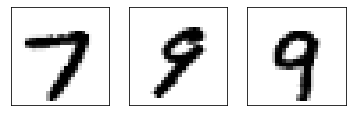

In [5]:
def plot_img(array,number=None):
    array = array.detach()
    array = array.reshape(array.shape[0],28,28)
    fig = plt.figure()
    for i in range(3):
      plt.subplot(130+i+1)
      plt.imshow(array[i],cmap='binary')
      plt.xticks([])
      plt.yticks([])
      if number:
          plt.xlabel(number,fontsize='x-large')
    plt.show()
    
image = next(iter( dataloader_mnist_train ))[0]
plot_img(image)

In [0]:
# defining generator class
class Generator(nn.Module):
    
    def __init__(self, inp, out):
        
        super(Generator, self).__init__()
        self.net = nn.Sequential(nn.Linear(inp,300),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(300,1000),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(1000,800),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(800,out))
        
    def forward(self, x):
        x = self.net(x)
        return x

# Aimed to introduce a random initialisation to our network. See bellow to know why.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# defining discriminator class
class Discriminator(nn.Module):
    def __init__(self, inp, out):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(nn.Linear(inp,600),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(600,300),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(300,300),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(300,200),
                                 nn.ReLU(inplace=True),
                                 nn.Linear(200,out),
                                 nn.Sigmoid() )
        
    def forward(self, x):
        x = self.net(x)
        return x



In [0]:
# In this case we got 2 models, Therefore we have to load 2 optimizers. 
# We load our two models
# We apply a random initialisation to our Generator's weights. It's help a lot 
# the Generator to create good images.


dis = Discriminator(28*28, 1).to(device)     # inp is the size of image, out is the output of our classification. Remember, it's a Binary classification !
gen = Generator(100, 28*28).to(device)
gen.apply(weights_init) # Try to uncoment this line and retrain all models from scratch ;) 

loss_func = nn.BCELoss().to(device)           #Binary cosentropy loss 
dis_optim = optim.Adam(dis.parameters())

gen_optim = optim.Adam(gen.parameters())

## It's finally time to train !

We have 2 networks to train in the same time. The training loop will be slightely different:
* Firstly : We will train the Discriminator Parameters.
  * We will **train** the discriminator with **real images**
  * After that, we will **train** him with **Generated images**
  * **Update** Discriminator parameters. 
* Secondly: We will **train** the Generator and update theses parameters.
  * We will **generate fake images** from the generator
  * We will **pass this fake images throw the discriminator** and finally **update** the Generator losses
  * **Note** : The aimed label of our generator is always 1 beceause we want 100% of sucess when we generate images. 



[0/938] D_loss : 1.3707659244537354; G_loss: 0.42556101083755493; D(x): 0.7501940727233887; D(G(x)): 1.0808966159820557)


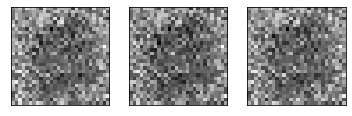

[100/938] D_loss : 0.3328453302383423; G_loss: 4.7691755294799805; D(x): 0.7750483751296997; D(G(x)): 0.07528555393218994)


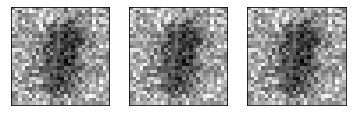

[200/938] D_loss : 1.3511135578155518; G_loss: 0.8149498701095581; D(x): 0.45260435342788696; D(G(x)): 0.557094156742096)


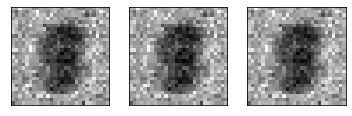

[300/938] D_loss : 0.8742818832397461; G_loss: 1.5158324241638184; D(x): 0.5020338296890259; D(G(x)): 0.18453529477119446)


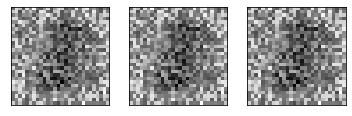

[400/938] D_loss : 1.7817716598510742; G_loss: 1.791335105895996; D(x): 0.5973946452140808; D(G(x)): 0.9715304970741272)


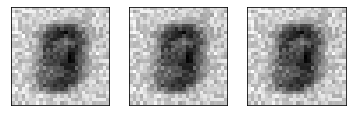

[500/938] D_loss : 1.437704086303711; G_loss: 1.0333187580108643; D(x): 0.6965303421020508; D(G(x)): 0.699808657169342)


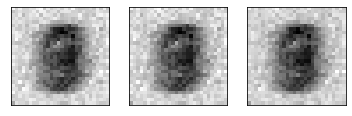

[600/938] D_loss : 2.3639466762542725; G_loss: 1.5466053485870361; D(x): 0.17014417052268982; D(G(x)): 0.1780025064945221)


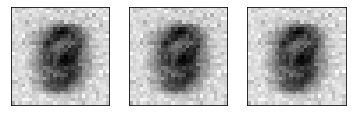

[700/938] D_loss : 0.4327031373977661; G_loss: 1.126401662826538; D(x): 0.99184250831604; D(G(x)): 0.42307496070861816)


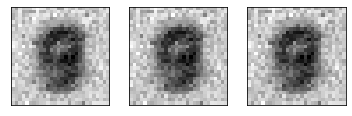

[800/938] D_loss : 0.38454800844192505; G_loss: 1.343163251876831; D(x): 0.9999185800552368; D(G(x)): 0.38446640968322754)


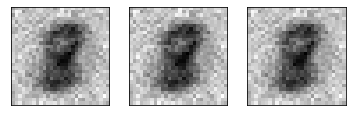

[900/938] D_loss : 0.315571129322052; G_loss: 2.526628017425537; D(x): 0.9611568450927734; D(G(x)): 0.2227470576763153)


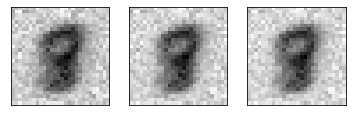

[0/938] D_loss : 3.1679186820983887; G_loss: 2.116814374923706; D(x): 0.13535065948963165; D(G(x)): 0.24777889251708984)


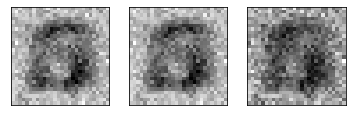

[100/938] D_loss : 0.06391710042953491; G_loss: 2.799708843231201; D(x): 1.0; D(G(x)): 0.06391710042953491)


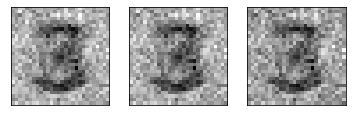

[200/938] D_loss : 0.5296774506568909; G_loss: 2.918562173843384; D(x): 0.8316333293914795; D(G(x)): 0.07549537718296051)


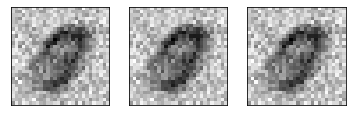

[300/938] D_loss : 0.5506336688995361; G_loss: 1.0284734964370728; D(x): 0.9566543698310852; D(G(x)): 0.49009963870048523)


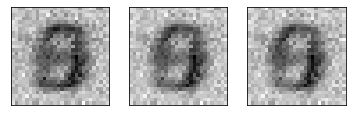

[400/938] D_loss : 0.672215461730957; G_loss: 1.5667150020599365; D(x): 0.8285448551177979; D(G(x)): 0.3370608389377594)


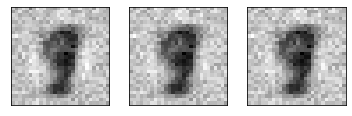

[500/938] D_loss : 0.7974567413330078; G_loss: 2.505972146987915; D(x): 0.6639604568481445; D(G(x)): 0.2835749387741089)


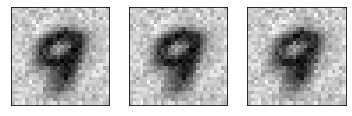

[600/938] D_loss : 1.445723295211792; G_loss: 0.9355258941650391; D(x): 0.4115164279937744; D(G(x)): 0.5570966005325317)


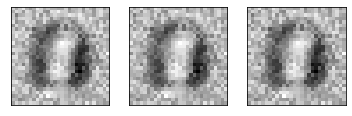

[700/938] D_loss : 0.20946954190731049; G_loss: 3.0473573207855225; D(x): 0.9982998967170715; D(G(x)): 0.20770923793315887)


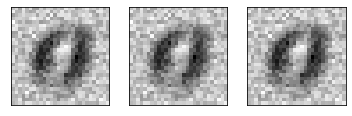

[800/938] D_loss : 0.057002343237400055; G_loss: 3.8376669883728027; D(x): 0.9999935626983643; D(G(x)): 0.056995853781700134)


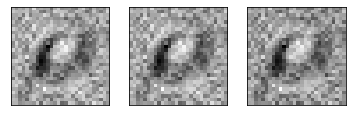

[900/938] D_loss : 0.614504337310791; G_loss: 6.633886814117432; D(x): 0.8135898113250732; D(G(x)): 0.004504087381064892)


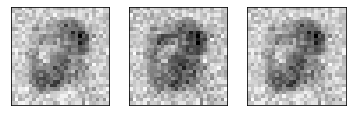

[0/938] D_loss : 1.3573533296585083; G_loss: 4.017996788024902; D(x): 0.8080546855926514; D(G(x)): 0.789053201675415)


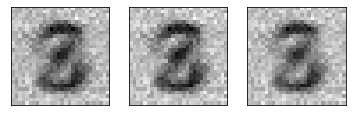

[100/938] D_loss : 0.6075245141983032; G_loss: 4.447491645812988; D(x): 0.8814469575881958; D(G(x)): 0.13404440879821777)


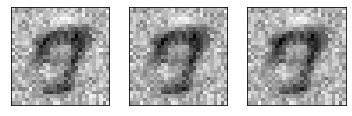

[200/938] D_loss : 1.0507657527923584; G_loss: 1.1342355012893677; D(x): 0.6349273920059204; D(G(x)): 0.4352390170097351)


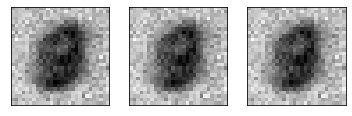

[300/938] D_loss : 0.019579894840717316; G_loss: 5.06807279586792; D(x): 0.9949841499328613; D(G(x)): 0.014128088019788265)


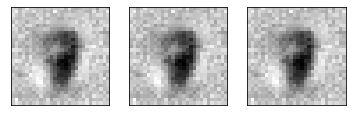

[400/938] D_loss : 0.9669763445854187; G_loss: 1.585580825805664; D(x): 0.5648339986801147; D(G(x)): 0.3144301772117615)


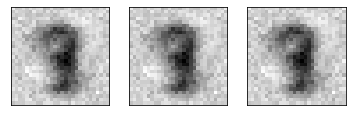

[500/938] D_loss : 0.46628808975219727; G_loss: 3.235185146331787; D(x): 0.8967469930648804; D(G(x)): 0.2843448519706726)


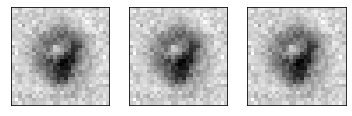

[600/938] D_loss : 0.008404352702200413; G_loss: 4.759884357452393; D(x): 0.9999465942382812; D(G(x)): 0.008350861258804798)


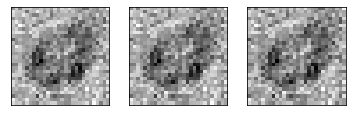

[700/938] D_loss : 6.028957366943359; G_loss: 48.07036590576172; D(x): 0.0514376163482666; D(G(x)): 0.0)


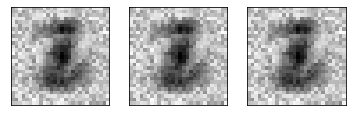

[800/938] D_loss : 0.3892361521720886; G_loss: 3.4892265796661377; D(x): 0.8528528213500977; D(G(x)): 0.12177668511867523)


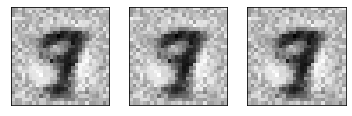

[900/938] D_loss : 1.0191872119903564; G_loss: 3.694791555404663; D(x): 0.6210212707519531; D(G(x)): 0.1724274903535843)


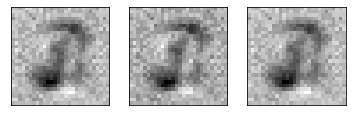

In [14]:
for epoch in range(EPOCHS):
  for i, batch in enumerate(dataloader_mnist_train):
    ############################
    # (1) Update D network: try to maximize log(D(x)) + log(1 - D(G(z)))
    ############################
    # Train with real images
    dis.zero_grad()                                                                         # Reset our gradients.
    real_batch = batch[0].reshape((batch[0].shape[0], -1 )).to(device)                      # Reshape all images to fit our network inputs.
    true_label = torch.ones((real_batch.shape[0])).to(device)                               # Get our expected outputs.
    dis_output = dis(real_batch).view(-1)                                                  
    err_dis_real = loss_func(dis_output, true_label)                                        # Get the loss of our predictions.
    err_dis_real.backward()                                                                 # Back propagation, 
    d_x = dis_output.mean().item()                                                          # Take the mean of all prediction in a given batch.

    # Secondly, we train with fake images, 
    noises = torch.randn( BATCH_SIZE, NZ, device=device )                                   # The noise tensors will be our Generator inputs.
    fake_label = torch.zeros((BATCH_SIZE))                                                  # Fake label for the discriminator, so this part won't want that, so it's 0.

    fake_output = gen(noises)                                                               # Generate few images with the Generator                          
    dis_output = dis(fake_output).view(-1)                                                  # Give these  fake images to the discriminator

    dis_err_fake = loss_func( dis_output.to(device), fake_label.to(device) )                                      # Compare prédictions to excpeted label ( in this line: 0)
    dis_err_fake.backward()                                                                 
    err_d = err_dis_real + dis_err_fake                                                     # We add these two losses to display the general Discriminator loss later
    d_g_x = dis_err_fake.item()                                                             # Take the confidance ratio of D(G(x)) 
    dis_optim.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ############################
    gen.zero_grad()
    noises = torch.randn( (BATCH_SIZE,100 ) )                                               # Make some noise tensors 
    gen_label = torch.ones( (BATCH_SIZE) )                                                  # Get Genrator excpeted label, in this case it's 1 beacause, the Generator,
                                                                                            # want to get a 1 (real image) prédiction from our discriminator.
    
    fake_images = gen(noises.to(device))                                                               # Generate some fake images.                                                       
    diss_output = dis(fake_images).view(-1)                                                 # Give these image to our discriminator
    gen_loss = loss_func(diss_output.to(device), gen_label.to(device))                                            # Compute the loss fonction (remember what I said above ;) )
    gen_loss.backward()
    gen_optim.step()

    if (i % PRINTING_STEP) == 0:
      print("[{}/{}] D_loss : {}; G_loss: {}; D(x): {}; D(G(x)): {})".format(
          i, len(dataloader_mnist_train), err_d.item(), gen_loss.item(), d_x, d_g_x))
      plot_img( fake_images.cpu().view(BATCH_SIZE, 28, 28) )
      plt.show()





      

